In [13]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
import quantstats as qs
import itertools
from tqdm import tqdm
# Import libraries for environment and model
from gym_anytrading.envs import StocksEnv, Actions, Positions
from stable_baselines3 import DQN

# High-quality figures
%config InlineBackend.figure_format = 'svg'

In [14]:
# Define hyperparameters ranges
buffer_sizes = [5000, 20000]
learning_start_values = [200, 1000]
train_freq_values = [1, 4]
batch_sizes = [4, 32]
policy_kwargs_options = [{'net_arch': [50]}, {'net_arch': [50, 100]}]
exploration_fractions = [0.05, 0.2]
gammas = [0.8, 0.95]
learning_rates = [0.1, 0.0001]

# Generate all combinations
all_combinations = list(itertools.product(
    buffer_sizes,
    learning_start_values,
    train_freq_values,
    batch_sizes,
    policy_kwargs_options,
    exploration_fractions,
    gammas,
    learning_rates 
))

simulation_time = 5
tau = 1e-4
nb_steps = int(simulation_time // tau)

In [15]:
# Define the total number of combinations for the progress bar
total_combinations = len(all_combinations)
total_combinations

256

In [16]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
mu_data = mu.history(start="2019-01-01", end="2023-09-30")

In [17]:
# Create a gym_anytrading environment using MU's stock data
env = gym.make('stocks-v0',
    df = pd.DataFrame(mu_data['Close']),
    window_size = 10,
    frame_bound = (10, len(mu_data)),
)

In [18]:
# Define evaluation functions that return performance metrics for the model
def get_profit(model):
    # Reset environment to its initial state
    observation, info = env.reset(seed=2023)

    # Initiate dictionary to store action counts
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}

    # Loop to apply the trained model on the environment
    while True:
        action, _states = model.predict(observation, deterministic = True)
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
           return info["total_profit"]

def get_reward(model):
    # Reset environment to its initial state
    observation, info = env.reset(seed=2023)

    # Initiate dictionary to store action counts
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}

    # Loop to apply the trained model on the environment
    while True:
        action, _states = model.predict(observation, deterministic = True)
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
           return info["total_reward"]

In [19]:
# Create a progress bar
progress_bar = tqdm(total=total_combinations, desc='Grid Search Progress', position=0, leave=True)

# Create dataframe to store results
results = pd.DataFrame(columns=["Parameters", "Total Reward", "Total Profit"])

# Grid Search
for combination in all_combinations:
    (buffer_size, learning_starts, train_freq, batch_size, policy_kwargs, exploration_fraction, gamma, learning_rate) = combination

    # Define the model
    model = DQN("MlpPolicy", env, buffer_size=buffer_size, learning_starts=learning_starts,
                train_freq=train_freq, batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs,
                exploration_fraction=exploration_fraction, learning_rate=learning_rate, target_update_interval=100,
                tau = 1e-4, verbose=0, seed = 2023)

    # Train the model
    model.learn(total_timesteps=nb_steps)

    # Evaluate the model
    reward = get_reward(model)
    profit = get_profit(model)
    
    if profit > 1.5:
        # Clean combination of parameters
        combination_strings = [str(item).replace('{', '').replace('}', '').replace('[', '').replace(']', '').replace(':', '').replace("'", '').replace(" ", "") for item in combination]
        result_string = '_'.join(combination_strings)
        
        # Save learned model as a zip file
        model.save(result_string)

    # Store results
    new_entry = {
    "Parameters": combination,
    "Total Reward": reward,  # Replace with your actual value
    "Total Profit": profit   # Replace with your actual value
    }
    
    # Append the new entry to the DataFrame
    results = pd.concat([results, pd.DataFrame([new_entry])], ignore_index=True)
    
    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

Grid Search Progress:   0%|          | 0/256 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Load optimized model
model = DQN.load("/saved_models/20000_200_4_4_net_arch50,100_0.2_0.8_0.0001")

FileNotFoundError: [Errno 2] No such file or directory: '\\saved_models\\20000_200_4_4_net_arch50,100_0.2_0.8_0.0001.zip'

In [ ]:
# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Initiate dictionary to store action counts
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Loop to apply the trained model on the environment
while True:
    action, _states = model.predict(observation, deterministic = True)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        print("action_stats:", action_stats)
        break

env.close()

info: {'total_reward': 17.305614471435547, 'total_profit': 1.8664583305981988, 'position': <Positions.Long: 1>}
action_stats: {<Actions.Sell: 0>: 2, <Actions.Buy: 1>: 1182}


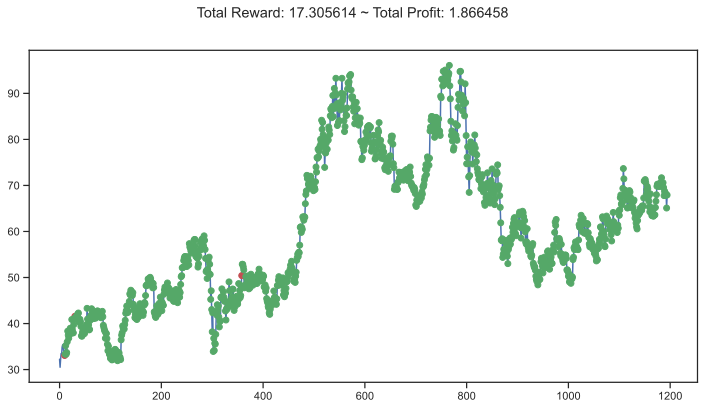

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
env.unwrapped.render_all()
plt.show()

In [ ]:
# Calculate metrics and visualize plots for the optimized DeepQ-Learning strategy
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.metrics(rl_returns)

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-14
Risk-Free Rate      0.0%
Time in Market      1.0%

Cumulative Return   86.65%
CAGR﹪              9.6%

Sharpe              0.8
Prob. Sharpe Ratio  99.97%
Sortino             -
Sortino/√2          -
Omega               -

Max Drawdown        %
Longest DD Days     -

Gain/Pain Ratio     -
Gain/Pain (1M)      -

Payoff Ratio        -
Profit Factor       -
Common Sense Ratio  -
CPC Index           -
Tail Ratio          -
Outlier Win Ratio   0.0
Outlier Loss Ratio  -

MTD                 26.51%
3M                  26.51%
6M                  26.51%
YTD                 26.51%
1Y                  26.51%
3Y (ann.)           5.72%
5Y (ann.)           9.6%
10Y (ann.)          9.6%
All-time (ann.)     9.6%

Recovery Factor     -
Ulcer Index         0.0
Serenity Index      -
Avg. Drawdown Days  -


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
results.to_csv("rl_models.csv", index=False)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

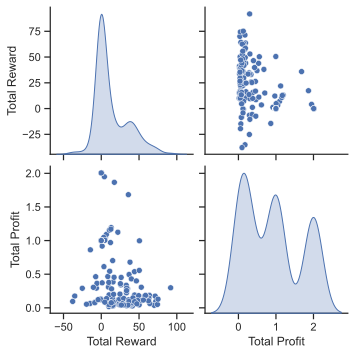

In [ ]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(results, diag_kind="kde", markers='o')

In [24]:
df = pd.read_csv("saved_models/rl_models.csv")